In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import patches, patheffects
import json
from collections import defaultdict

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms

In [2]:
DATA_DIR = Path("../data/")
train_ids = DATA_DIR/'processed'/'PascalVOC'/'train'/'VOCDevkit'/'VOC2007'/'ImageSets'/'Layout'/'train.txt'
valid_ids = DATA_DIR/'processed'/'PascalVOC'/'train'/'VOCDevkit'/'VOC2007'/'ImageSets'/'Layout'/'val.txt'
jpgs = DATA_DIR/'processed'/'PascalVOC'/'train'/'VOCDevkit'/'VOC2007'/'JPEGImages'
json_paths = {'train': DATA_DIR/'processed'/'PascalVOC'/'train'/'pascal_train2007.json',
         'valid': DATA_DIR/'processed'/'PascalVOC'/'train'/'pascal_val2007.json'}

In [3]:
def get_jpgs(ids):
    jpgs = []
    with open(ids) as f:
        for l in f.readlines():
            jpgs.append(l.strip() + ".jpg")
    return jpgs

In [100]:
jpgs

PosixPath('../data/processed/PascalVOC/train/VOCDevkit/VOC2007/JPEGImages')

In [99]:
train_ids

PosixPath('../data/processed/PascalVOC/train/VOCDevkit/VOC2007/ImageSets/Layout/train.txt')

In [4]:
train_files = [jpgs/ext for ext in get_jpgs(train_ids)]
valid_files = [jpgs/ext for ext in get_jpgs(valid_ids)]

In [5]:
infos = {phase: json.load(json_paths[phase].open()) for phase in json_paths}

In [104]:
infos['train']['images']

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32},
 {'file_name': '000033.jpg', 'height': 366, 'width': 500, 'id': 33},
 {'file_name': '000034.jpg', 'height': 500, 'width': 360, 'id': 34},
 {'file_name': '000035.jpg', 'height': 375, 'width': 500, 'id': 35},
 {'file_name': '000036.jpg', 'height': 500, 'width': 332, 'id': 36},
 {'file_name': '000042.jpg', 'height': 335, 'width': 500, 'id': 42},
 {'file_name': '000044.jpg', 'height': 333, 'width': 500, 'id': 44},
 {'file_name': '000047.jpg', 'height': 333, 'width': 500, 'id': 47},
 {'file_name': '000048.jpg', 'height': 500, 'width': 375, 'id': 48},
 {'file_name': '000061.jpg', 'height': 333, 'width': 500, 'id': 61},
 {'file_name': '000064.jpg', 'heig

In [8]:
infos['train']['annotations']

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0},
 {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
  'area': 81326,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [89, 77, 314, 259],
  'category_id': 13,
  'id': 3,
  'ignore': 0},
 {'segmentation': [[8, 229, 8, 500, 245, 500, 245, 229]],
  'area': 64227,
  'iscrowd': 0,
  'image_id': 23,
  'bbox': [8, 229, 237, 271],
  'category_id': 2,
  'id': 4,
  'ignore': 0},
 {'segmentation': [[229, 219, 229, 500, 334, 500, 334, 219]],
  'area': 29505,
  'iscrowd': 0,
  'image_id': 23,
  'bbox': [229, 219, 105, 281],
  'category_id': 2,
  'id': 5,
  'ignore': 0},
 {'segmentation': [[1, 177, 1, 500, 90, 500, 90, 177]],
 

In [7]:
imgs = {}
for phase in infos:
    imgs.update({d['id']: jpgs/d['file_name'] for d in infos[phase]['images']})

In [8]:
annos = {}
for phase in infos:
    d = defaultdict(list)
    for anno in infos[phase]['annotations']:
        d[anno['image_id']].append(anno)
    annos.update(d)

In [9]:
def draw_rec(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [10]:
def hw_bb(bb): 
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [11]:
def show_img(img_id, annos):
    fig, ax = plt.subplots()
    im = Image.open(imgs[img_id])
    bboxs = [anno['bbox'] for anno in annos[img_id]]
    ax.imshow(im)
    for bbox in bboxs:
        draw_rec(ax, bbox)
    im.close()
    

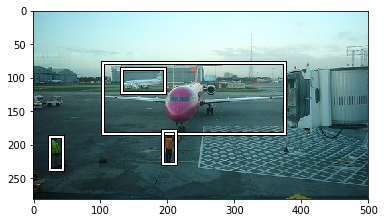

In [12]:
show_img(32, annos)

In [13]:
largest_annos = {}
for img_id, anno_list in annos.items():
    largest_idx = np.argmax([anno['area'] for anno in anno_list])
    largest_annos[img_id] = anno_list[largest_idx]

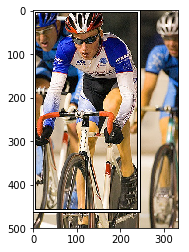

In [14]:
show_img(23, {k: [v] for k, v in largest_annos.items()})

In [85]:
class BBoxDataset(torch.utils.data.Dataset):

    def __init__(self, files, annos, transform=None):
        self.transform = transform
        self.files = files
        self.annos = annos

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        file_id = self.get_file_id(file)
        label = self.annos[file_id]['category_id']
        with open(file, 'rb') as f:
            img = Image.open(f)
            sample = img.convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, torch.tensor(label, dtype=torch.int32)

    def get_file_id(self, file):
        return int(file.name.split(".")[0])

In [86]:
train_files[:3]

[PosixPath('../data/processed/PascalVOC/train/VOCDevkit/VOC2007/JPEGImages/000012.jpg'),
 PosixPath('../data/processed/PascalVOC/train/VOCDevkit/VOC2007/JPEGImages/000026.jpg'),
 PosixPath('../data/processed/PascalVOC/train/VOCDevkit/VOC2007/JPEGImages/000034.jpg')]

In [87]:
f = train_files[0]

In [88]:
int(f.name.split(".")[0])

12

In [89]:
normalize = transforms.Normalize(mean=[0., 0., 0.],
                                     std=[1., 1., 1.])
ds = BBoxDataset(train_files, largest_annos, transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

In [90]:
im, label = ds[9]

In [91]:
label

tensor(7, dtype=torch.int32)

In [92]:
im.shape

torch.Size([3, 224, 224])

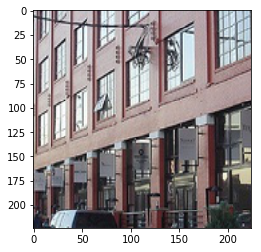

In [93]:
plt.imshow(im.numpy().transpose(1, 2, 0))

In [94]:
loader = torch.utils.data.DataLoader(ds, batch_size=4, shuffle=True)

In [95]:
x, y = next(iter(loader))

In [96]:
x.shape

torch.Size([4, 3, 224, 224])

In [97]:
y.shape

torch.Size([4])

In [98]:
y

tensor([15,  6, 15,  6], dtype=torch.int32)